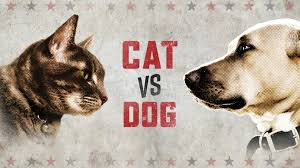


## Cats vs Dogs

### 📖 Background

It has always been a great debate over whether dog or cat is more popular as a pet. In this workbook, we're going to analyze dogs vs cats ownership in UK and find out the answer

## Finding summary

1. Dogs are more popular than cats in all regions across the UK (Dogs per household is always higher than Cats per household on town/county/region level)
2. Pet ownership is higher in urban area than metropolitan area, possibly due to more favourable environment settings. South and South West areas have higher pets per household than other areas.
3. Population has a positive but not very strong relationship with pet ownership. This suggest that there might be other factors impacting pets ownership: eg. disposable income, culture, ... 
4. Meanwhile, population density does not have any impact on pet ownership. This suggests that space constraints might not be a big problem for pet ownership in the UK and that other factors play a more impactful role.


### 💾 The data

There are 5 datasets used in the workbook, which contain the data as follows below.

#### The `population_per_postal_code.csv` data contains these columns:

| Column | Description |
|---------|----------------------------------------|  
| `postal_code` | An identifier for each postal code area|
| `estimated_cat_population` | The estimated cat population for the postal code area |  
| `estimated_dog_population` | The estimated cat population for the postal code area |


#### The `avg_per_household.csv` data contains these columns:

| Column | Description |
|---------|----------------------------------------|  
| `postal_code` | An identifier for each postal code area|
| `cats_per_household` | The average number of cats per household in the postal code area |  
| `dog_per_household` | The average number of dogs per household in the postal code area |

#### The `postal_code_areas.csv` data contains these columns:

| Column | Description |
|---------|----------------------------------------|  
| `postal_code` | An identifier for each postal code area|
| `town` | The town/towns which are contained in the postal code area |  
| `county` | The UK county that the postal code area is located in |
| `population` | The population of people in each postal code area |
| `num_households` | The number of households in each postal code area |
| `uk_region` | The region in the UK which the postal code is located in |

#### The `ukpostcodes.csv` data contains these columns:
| Column | Description |
|---------|----------------------------------------|  
| `postcode` | An identifier for each postal code area|
| `longitude` | Longitude of the postal code area |  
| `latitude` | Latitude of the postal code area |

#### The `area` data contains these columns:
| Column | Description |
|---------|----------------------------------------|  
| `Rank` | Alphabetical ranking of districts |
| `District` | Districts within the postal code area | 
| `Area (km²)` | Land area of the district in square kilometers |
| `Area (mi²)` | Land area of the district in square miles |
| `Type` | Classification of the district |
| `Ceremonial county` | Ceremonial county in the UK where the postal code is located |
| `Region` | UK region where the postal code is situated |

***Acknowledgments**: 
Data has been assembled and modified from these sources: [Animal and Plant Health Agency](https://www.data.gov.uk/search?filters%5Bpublisher%5D=Animal+and+Plant+Health+Agency), [Postcodes](
https://ideal-postcodes.co.uk/guides/postcode-areas), [Free Map Tools](https://www.freemaptools.com/download-uk-postcode-lat-lng.htm), [Wikipedia](https://en.wikipedia.org/wiki/List_of_English_districts_by_area).

# Part I.  Loading datasets & merge

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import branca
from shapely.geometry import MultiPoint
import plotly.express as px
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score

pd.set_option('display.width', None)  
pd.set_option('display.max_columns', None)  

In [101]:
population_raw_data = pd.read_csv('data/population_per_postal_code.csv')
population_raw_data

postal_code estimated_cat_population estimated_dog_population
0           AB10                 1,675.72                 1,921.75
1           AB11                 2,072.99                 2,377.35
2           AB12                 3,601.57                 4,130.35
3           AB13                 1,153.84                 1,323.24
4           AB14                 2,325.13                 2,666.50
...          ...                      ...                      ...
2825         YO8                 5,115.47                 5,866.53
2826         ZE1                 1,895.51                 2,173.81
2827         ZE2                 4,586.34                 5,259.71
2828         ZE3              105.0080493              120.4254386
2829        YO90                        0                        0

[2830 rows x 3 columns]

In [102]:
avg_raw_data = pd.read_csv('data/avg_per_household.csv')
avg_raw_data

postcode  cats_per_household  dogs_per_household
0        AB10            0.164463            0.188610
1        AB11            0.206145            0.236411
2        AB12            0.300306            0.344397
3        AB13            1.145815            1.314045
4        AB14            1.008732            1.156835
...       ...                 ...                 ...
2825      YO8            0.261034            0.299359
2826      ZE1            0.454124            0.520799
2827      ZE2            0.677350            0.776799
2828      ZE3            0.458550            0.525875
2829     YO90            0.000000            0.000000

[2830 rows x 3 columns]

In [103]:
postcodes_raw_data = pd.read_csv('data/postal_codes_areas.csv')
postcodes_raw_data

postal_code                             town    county  population  \
0            AB1                         Aberdeen  Aberdeen         NaN   
1            AB2                         Aberdeen  Aberdeen         NaN   
2            AB3                         Aberdeen  Aberdeen         NaN   
3            AB4  Fraserburgh, Peterhead, Macduff  Aberdeen         NaN   
4            AB5        Buckie, Huntly, Inverurie  Aberdeen         NaN   
...          ...                              ...       ...         ...   
3110        YO91         Lawrence Court, PO Boxes      York         NaN   
3111        YO95                      Pocklington      York         NaN   
3112         ZE1               Lerwick, Scalloway  Shetland      8445.0   
3113         ZE2                         Shetland  Shetland     14209.0   
3114         ZE3                             Bush  Shetland       432.0   

      num_households                 uk_region  
0                NaN                  Scotland  
1                NaN                  Scotland  
2                NaN                  Scotland  
3                NaN                  Scotland  
4                NaN                  Scotland  
...              ...                       ...  
3110             NaN  Yorkshire and The Humber  
3111             NaN  Yorkshire and The Humber  
3112          3862.0                  Scotland  
3113          5845.0                  Scotland  
3114           208.0                  Scotland  

[3115 rows x 6 columns]

In [104]:
ukpostcode = pd.read_csv('data/ukpostcodes.csv')
ukpostcode['postcode'] = ukpostcode['postcode'].str.split().str[0]
ukpostcode_grouped = ukpostcode.groupby(by='postcode', as_index=False)[['longitude', 'latitude']].mean()
ukpostcode_grouped

postcode  longitude   latitude
0        AB10  -2.120314  57.135237
1        AB11  -2.092920  57.139210
2        AB12  -2.112723  57.102017
3        AB13  -2.235035  57.107706
4        AB14  -2.271415  57.100517
...       ...        ...        ...
2968      YO8  -1.060497  53.781150
2969     YO90  -1.090250  53.959708
2970      ZE1  -1.171101  60.151440
2971      ZE2  -1.228607  60.311017
2972      ZE3  -1.304358  59.882947

[2973 rows x 3 columns]

In [105]:
#create merged dataset
df_merged = postcodes_raw_data.merge(avg_raw_data, left_on="postal_code", right_on="postcode", how="inner") \
                             .merge(population_raw_data, on="postal_code", how ="inner") \
                             .merge(ukpostcode_grouped, left_on = "postal_code",right_on= "postcode", how = "left")\
                             .drop(columns=["postcode_x","postcode_y"])

df_merged

postal_code                                               town  \
0           AB10    Aberdeen city centre, Bridge of Dee, Mannofield   
1           AB11                        Aberdeen city centre, Torry   
2           AB12  Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...   
3           AB13                                         Milltimber   
4           AB14                        Peterculter, Upper Anguston   
...          ...                                                ...   
2825        YO62              Thorpe Hall, Helmsley, Kirkbymoorside   
2826        YO90                         Rougier St, Wellington Row   
2827         ZE1                                 Lerwick, Scalloway   
2828         ZE2                                           Shetland   
2829         ZE3                                               Bush   

               county  population  num_households                 uk_region  \
0            Aberdeen     21964.0         11517.0                  Scotland   
1            Aberdeen     21237.0         10926.0                  Scotland   
2            Aberdeen     25414.0         10688.0                  Scotland   
3            Aberdeen      2725.0           947.0                  Scotland   
4            Aberdeen      4881.0          2162.0                  Scotland   
...               ...         ...             ...                       ...   
2825  North Yorkshire     11979.0          5116.0  Yorkshire and The Humber   
2826             York         NaN             NaN  Yorkshire and The Humber   
2827         Shetland      8445.0          3862.0                  Scotland   
2828         Shetland     14209.0          5845.0                  Scotland   
2829         Shetland       432.0           208.0                  Scotland   

      cats_per_household  dogs_per_household estimated_cat_population  \
0               0.164463            0.188610                 1,675.72   
1               0.206145            0.236411                 2,072.99   
2               0.300306            0.344397                 3,601.57   
3               1.145815            1.314045                 1,153.84   
4               1.008732            1.156835                 2,325.13   
...                  ...                 ...                      ...   
2825            1.256223            1.440663                 7,248.41   
2826            0.000000            0.000000                        0   
2827            0.454124            0.520799                 1,895.51   
2828            0.677350            0.776799                 4,586.34   
2829            0.458550            0.525875              105.0080493   

     estimated_dog_population  longitude   latitude  
0                    1,921.75  -2.120314  57.135237  
1                    2,377.35  -2.092920  57.139210  
2                    4,130.35  -2.112723  57.102017  
3                    1,323.24  -2.235035  57.107706  
4                    2,666.50  -2.271415  57.100517  
...                       ...        ...        ...  
2825                 8,312.63  -0.993841  54.246440  
2826                        0  -1.090250  53.959708  
2827                 2,173.81  -1.171101  60.151440  
2828                 5,259.71  -1.228607  60.311017  
2829              120.4254386  -1.304358  59.882947  

[2830 rows x 12 columns]

# Part II. Cleaning & Transforming data
- Estimated_cat_population and estimated_dog_population are stored as string, we need to convert them to float
- Missing cats_per_household and dogs_per_household data (stored as 0), these data points were removed
- Remove rows where estimated_cat_population & estimated_dog population <1. It is unreasonable to have pets population <1
- Null values in population and num_households. We fill in the data based on estimation using dogs_per_household and estmated_dog_population
- After cleaning the data, we run a final check to see the distribution and correlation between variables in the dataset

In [106]:
df_merged.dtypes

postal_code                  object
town                         object
county                       object
population                  float64
num_households              float64
uk_region                    object
cats_per_household          float64
dogs_per_household          float64
estimated_cat_population     object
estimated_dog_population     object
longitude                   float64
latitude                    float64
dtype: object

In [107]:
#change datatype
df_merged['estimated_cat_population'] = df_merged['estimated_cat_population'].astype(str).str.replace(',', '', regex=True).astype(float)
df_merged['estimated_dog_population'] = df_merged['estimated_dog_population'].astype(str).str.replace(',', '', regex=True).astype(float)

In [108]:
df_merged.describe()

population  num_households  cats_per_household  dogs_per_household  \
count    2734.000000     2734.000000         2830.000000         2830.000000   
mean    22445.430871     9413.558888            0.451960            0.518317   
std     16649.370756     6850.879208            0.401342            0.460267   
min         2.000000        1.000000            0.000000            0.000000   
25%      9195.750000     3992.750000            0.196758            0.225646   
50%     20422.000000     8654.500000            0.340893            0.390943   
75%     32520.250000    13602.500000            0.592085            0.679015   
max    153812.000000    61886.000000            5.212126            5.977375   

       estimated_cat_population  estimated_dog_population    longitude  \
count               2830.000000               2830.000000  2825.000000   
mean                3574.121561               4098.877737    -1.916509   
std                 3175.924642               3642.217209     1.714131   
min                    0.000000                  0.000000    -7.473563   
25%                 1223.782500               1403.455000    -3.054909   
50%                 2794.390000               3204.665000    -1.817325   
75%                 5085.580000               5832.255000    -0.427237   
max                23544.450000              27001.270000     1.731360   

          latitude  
count  2825.000000  
mean     52.997346  
std       1.879567  
min      49.895171  
25%      51.514373  
50%      52.534157  
75%      53.820071  
max      60.311017

In [109]:
#remove 0 values
df_merged = df_merged.loc[df_merged[['cats_per_household', 'dogs_per_household', 
                                    'estimated_cat_population', 'estimated_dog_population']].ne(0).any(axis=1)]

#remove rows where estimated_cat_population & estimated_dog population <1
df_merged = df_merged[~((df_merged['estimated_cat_population'] < 1) & (df_merged['estimated_dog_population'] < 1))]

In [110]:
df_merged.isnull().sum()

postal_code                 0
town                        0
county                      0
population                  4
num_households              4
uk_region                   0
cats_per_household          0
dogs_per_household          0
estimated_cat_population    0
estimated_dog_population    0
longitude                   0
latitude                    0
dtype: int64

In [111]:
# fill in num_households based on dogs population and dogs per household
df_merged.loc[df_merged['num_households'].isna(), 'num_households'] = (
    df_merged['estimated_dog_population'] / df_merged['dogs_per_household']).round()

#fill in population using estimation with num_households
population_household_ratio = df_merged['population'].mean()/df_merged['num_households'].mean()
df_merged.loc[df_merged['population'].isna(),'population'] = (df_merged['num_households']*population_household_ratio).round()

In [112]:
df_merged.duplicated().sum()

0


--- Data Overview ---
  postal_code                                               town    county  \
0        AB10    Aberdeen city centre, Bridge of Dee, Mannofield  Aberdeen   
1        AB11                        Aberdeen city centre, Torry  Aberdeen   
2        AB12  Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...  Aberdeen   
3        AB13                                         Milltimber  Aberdeen   
4        AB14                        Peterculter, Upper Anguston  Aberdeen   

   population  num_households uk_region  cats_per_household  \
0     21964.0         11517.0  Scotland            0.164463   
1     21237.0         10926.0  Scotland            0.206145   
2     25414.0         10688.0  Scotland            0.300306   
3      2725.0           947.0  Scotland            1.145815   
4      4881.0          2162.0  Scotland            1.008732   

   dogs_per_household  estimated_cat_population  estimated_dog_population  \
0            0.188610                   1675.72     

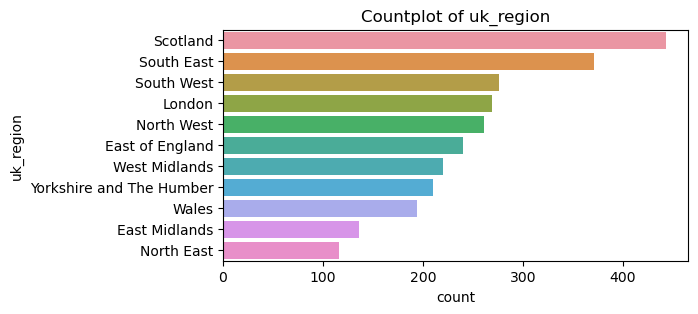


--- Correlation Heatmap ---


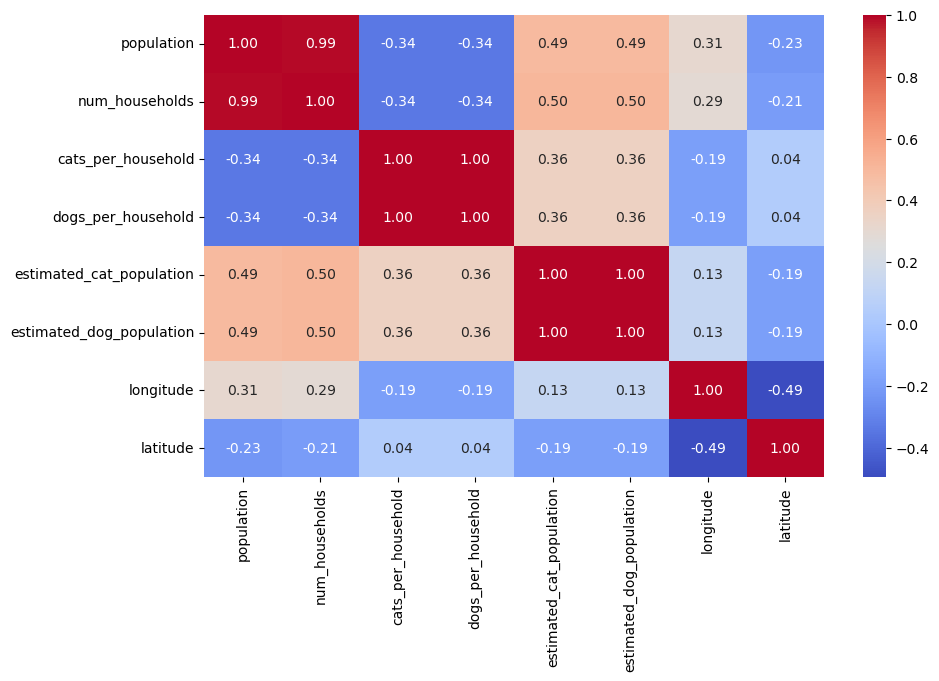


--- Boxplots for Outliers ---


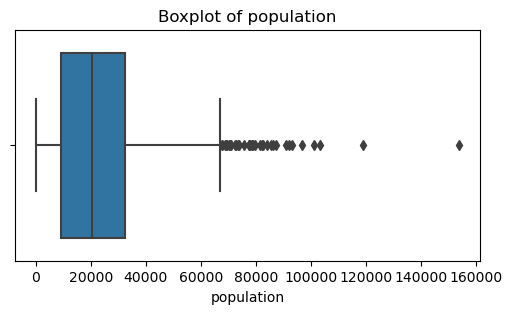

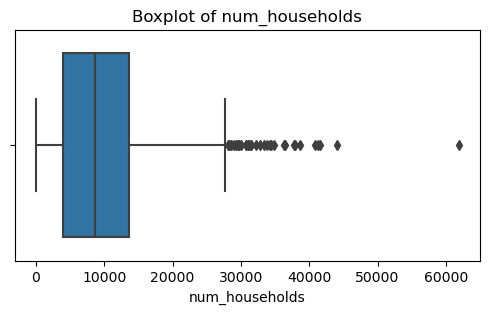

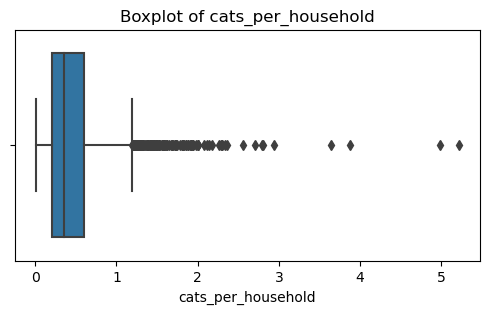

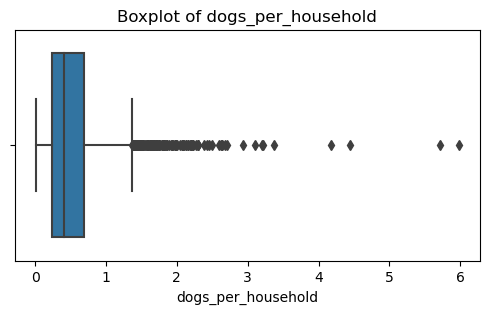

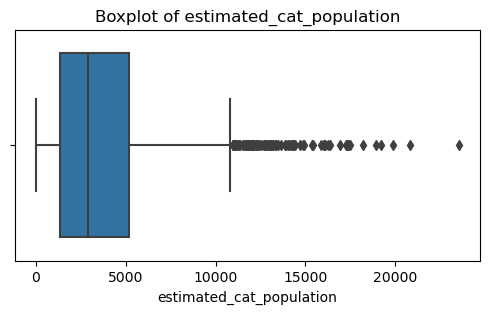

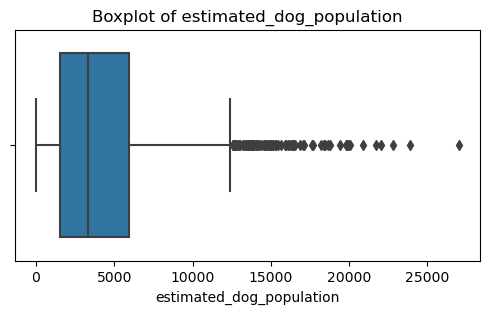

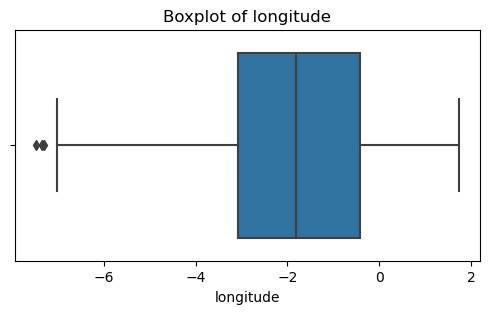

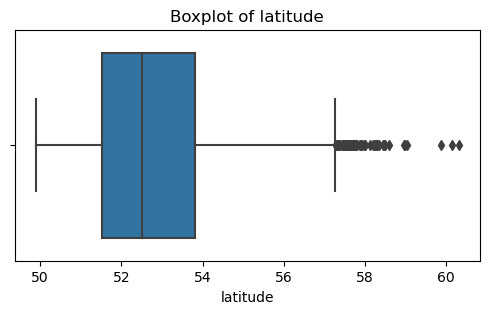


--- Histograms ---


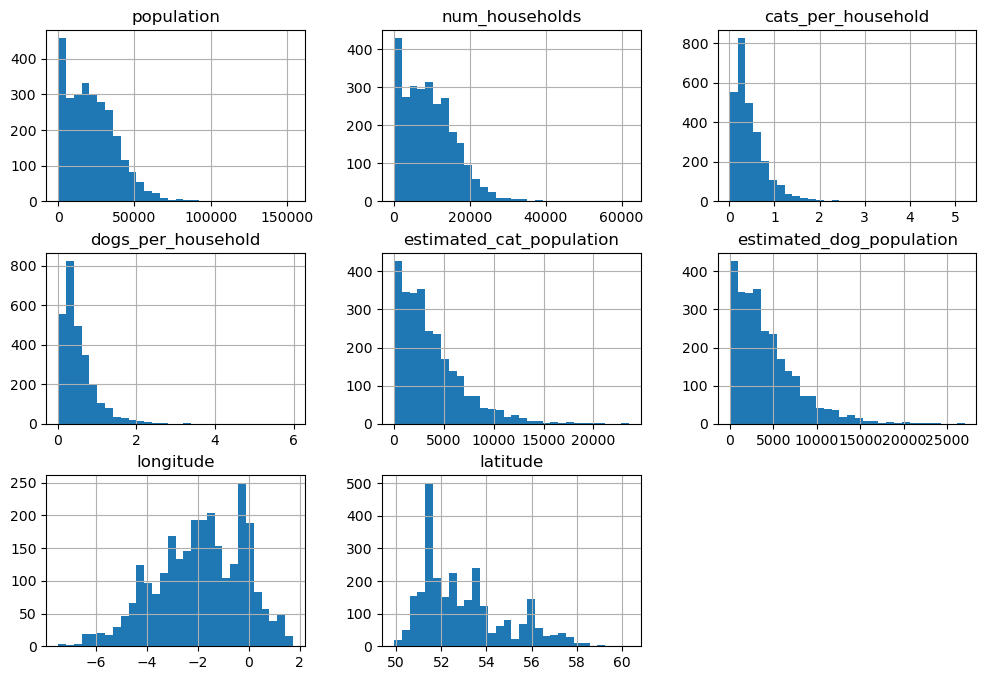

postal_code                                               town  \
0           AB10    Aberdeen city centre, Bridge of Dee, Mannofield   
1           AB11                        Aberdeen city centre, Torry   
2           AB12  Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...   
3           AB13                                         Milltimber   
4           AB14                        Peterculter, Upper Anguston   
...          ...                                                ...   
2824        YO61                                         Easingwold   
2825        YO62              Thorpe Hall, Helmsley, Kirkbymoorside   
2827         ZE1                                 Lerwick, Scalloway   
2828         ZE2                                           Shetland   
2829         ZE3                                               Bush   

               county  population  num_households                 uk_region  \
0            Aberdeen     21964.0         11517.0                  Scotland   
1            Aberdeen     21237.0         10926.0                  Scotland   
2            Aberdeen     25414.0         10688.0                  Scotland   
3            Aberdeen      2725.0           947.0                  Scotland   
4            Aberdeen      4881.0          2162.0                  Scotland   
...               ...         ...             ...                       ...   
2824  North Yorkshire     13914.0          5939.0  Yorkshire and The Humber   
2825  North Yorkshire     11979.0          5116.0  Yorkshire and The Humber   
2827         Shetland      8445.0          3862.0                  Scotland   
2828         Shetland     14209.0          5845.0                  Scotland   
2829         Shetland       432.0           208.0                  Scotland   

      cats_per_household  dogs_per_household  estimated_cat_population  \
0               0.164463            0.188610               1675.720000   
1               0.206145            0.236411               2072.990000   
2               0.300306            0.344397               3601.570000   
3               1.145815            1.314045               1153.840000   
4               1.008732            1.156835               2325.130000   
...                  ...                 ...                       ...   
2824            1.933740            2.217654              12043.330000   
2825            1.256223            1.440663               7248.410000   
2827            0.454124            0.520799               1895.510000   
2828            0.677350            0.776799               4586.340000   
2829            0.458550            0.525875                105.008049   

      estimated_dog_population  longitude   latitude  
0                  1921.750000  -2.120314  57.135237  
1                  2377.350000  -2.092920  57.139210  
2                  4130.350000  -2.112723  57.102017  
3                  1323.240000  -2.235035  57.107706  
4                  2666.500000  -2.271415  57.100517  
...                        ...        ...        ...  
2824              13811.550000  -1.196049  54.117710  
2825               8312.630000  -0.993841  54.246440  
2827               2173.810000  -1.171101  60.151440  
2828               5259.710000  -1.228607  60.311017  
2829                120.425439  -1.304358  59.882947  

[2736 rows x 12 columns]

In [113]:
def explore_data(df, categorical_columns = None, numerical_columns = None):
    try:
        print("\n--- Data Overview ---")
        print(df.head())
        print("\n--- Data Info ---")
        print(df.info())
        print("\n--- Missing Values ---")
        print(df.isnull().sum())
        print("\n--- Duplicates ---")
        print("Total Duplicates:", df.duplicated().sum())

        print("\n--- Summary Statistics ---")
        print(df.describe())

        print("\n--- Categorical Variables Summary ---")

        if categorical_columns is None:
            categorical_columns = df.select_dtypes(include=['object', 'category']).columns

        for col in categorical_columns:
            print(f"\nValue Counts for {col}:")
            print(df[col].value_counts())

            plt.figure(figsize=(6, 3))
            sns.countplot(y=df[col], order=df[col].value_counts().index)
            plt.title(f"Countplot of {col}")
            plt.show()
        
        if len(categorical_columns) == 0:
            print("Skipped this part. There is no categorical variables")

        print("\n--- Correlation Heatmap ---")
        
        if numerical_columns is None:
            numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
            
        if len(df[numerical_columns].corr()) >= 2:
            plt.figure(figsize=(10, 6))
            sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
            plt.show()
        else:
            print("Skip this part. There are not enough numerical variables")

        print("\n--- Boxplots for Outliers ---")
        
     
        for col in numerical_columns:
            plt.figure(figsize=(6, 3))
            sns.boxplot(x=df[col])
            plt.title(f"Boxplot of {col}")
            plt.show()
        if len(numerical_columns) == 0:
            print("Skipped this part. There is no numerical variables")

        print("\n--- Histograms ---")
        df.hist(figsize=(12, 8), bins=30)
        plt.show()
    except Exception as e:
            print(f"Skipped this part. Error")
    return df


explore_data(df_merged,categorical_columns = ["uk_region"])

## Comments  

1. After cleaning the data, we ended up with 2736 records. From the correlation heatmap, we can see a very strong correlation between population and num_households (which is totally reasonable as population increases, num_households will increase).</span>  

2. It's noticeable that the correlation between cats_per_household and dogs_per_household is 1, which implies a perfect linear relationship between these two variables. This suggests that the popularity of both types of pets moves together and that one does not necessarily decline for the benefit of the other.</span>  

3. Except for longitude and latitude, all other numerical variables are left-skewed.</span>  


# Part III. Dogs vs Cat, which one is more popular

In [114]:
df_merged["estimated_pet_population"] = df_merged["estimated_cat_population"]+df_merged["estimated_dog_population"]
df_merged['dog_preference'] = df_merged.apply(lambda row: 1 if row['dogs_per_household'] > row['cats_per_household'] else 0, axis=1)
df_merged["pets_per_household"]= df_merged.apply(lambda row: row["cats_per_household"]+row["dogs_per_household"], axis =1)

In [115]:
df_merged["dog_preference"].describe()

count    2736.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: dog_preference, dtype: float64

In [116]:
df_merged.drop(columns ="dog_preference", inplace= True)

In [117]:
print(df_merged[['dogs_per_household','cats_per_household','estimated_dog_population','estimated_cat_population']].mean())

dogs_per_household             0.535887
cats_per_household             0.467280
estimated_dog_population    4239.701515
estimated_cat_population    3696.916466
dtype: float64


## Comments

<span style="font-size: 1.2em;">As can be seen, dogs is more popular than cat in all data points in our dataset. 

# Part IV. Region Analysis

In [118]:
# weighted average function
wm = lambda x: np.average(x, weights=df_merged.loc[x.index, "num_households"])

#create region dataset
region_grouped = df_merged.groupby('uk_region').agg(
    population=('population', 'sum'),  # Sum of population
    num_households=('num_households', 'sum'),  # Sum of num_households
    cats_per_household=('cats_per_household',wm),
    dogs_per_household=('dogs_per_household', wm),
    pets_per_household=('pets_per_household', wm),
    longitude=('longitude', 'mean'),
    latitude=('latitude', 'mean'),
).reset_index()

In [119]:
# sort the data by pets_per_household
region_grouped.sort_values(by="pets_per_household",ascending=False, inplace=True)

# create a bar chart
fig = px.bar(region_grouped, 
             x='uk_region', 
             y=['dogs_per_household', 'cats_per_household'], 
             title='Pets per Household by Region',
             barmode='group')  # This ensures the bars for each region are grouped

fig.show()


In [120]:
# create polygon map using folium

# define map center
m = folium.Map(location=[df_merged['latitude'].mean()+1, df_merged['longitude'].mean()], zoom_start=6.1)

# define color map
colormap = branca.colormap.linear.YlOrRd_09.scale(region_grouped['pets_per_household'].min(), region_grouped['pets_per_household'].max())
colormap.add_to(m)

# create a convex hull for each region
for region, group in df_merged.groupby('uk_region'):
    # create MultiPoint object 
    points = [tuple(x) for x in group[['longitude', 'latitude']].values]
    multipoint = MultiPoint(points)
    hull = multipoint.convex_hull
    hull_coords = [(p[1], p[0]) for p in list(hull.exterior.coords)]

    # get pets_per_household for the region
    region_pets_per_household = region_grouped.loc[region_grouped['uk_region'] == region, 'pets_per_household'].values[0]

    # get the color for the polygon based on the 'pets_per_household' value
    polygon_color = colormap(region_pets_per_household)

    # create a polygon
    folium.Polygon(
        locations=hull_coords,
        color='gray', 
        weight=1, 
        fill=True,
        fill_color=polygon_color,  
        fill_opacity=0.6 
    ).add_to(m)

    # calculate controid of region
    centroid_lat = sum([p[0] for p in hull_coords]) / len(hull_coords)
    centroid_lon = sum([p[1] for p in hull_coords]) / len(hull_coords)

    # add region label
    folium.Marker(
        location=[centroid_lat, centroid_lon],
        icon=folium.DivIcon(html=f'<div style="font-size: 10px; color: black; font-weight: bold;">{region}</div>')  # Label with text
    ).add_to(m)


#display
m


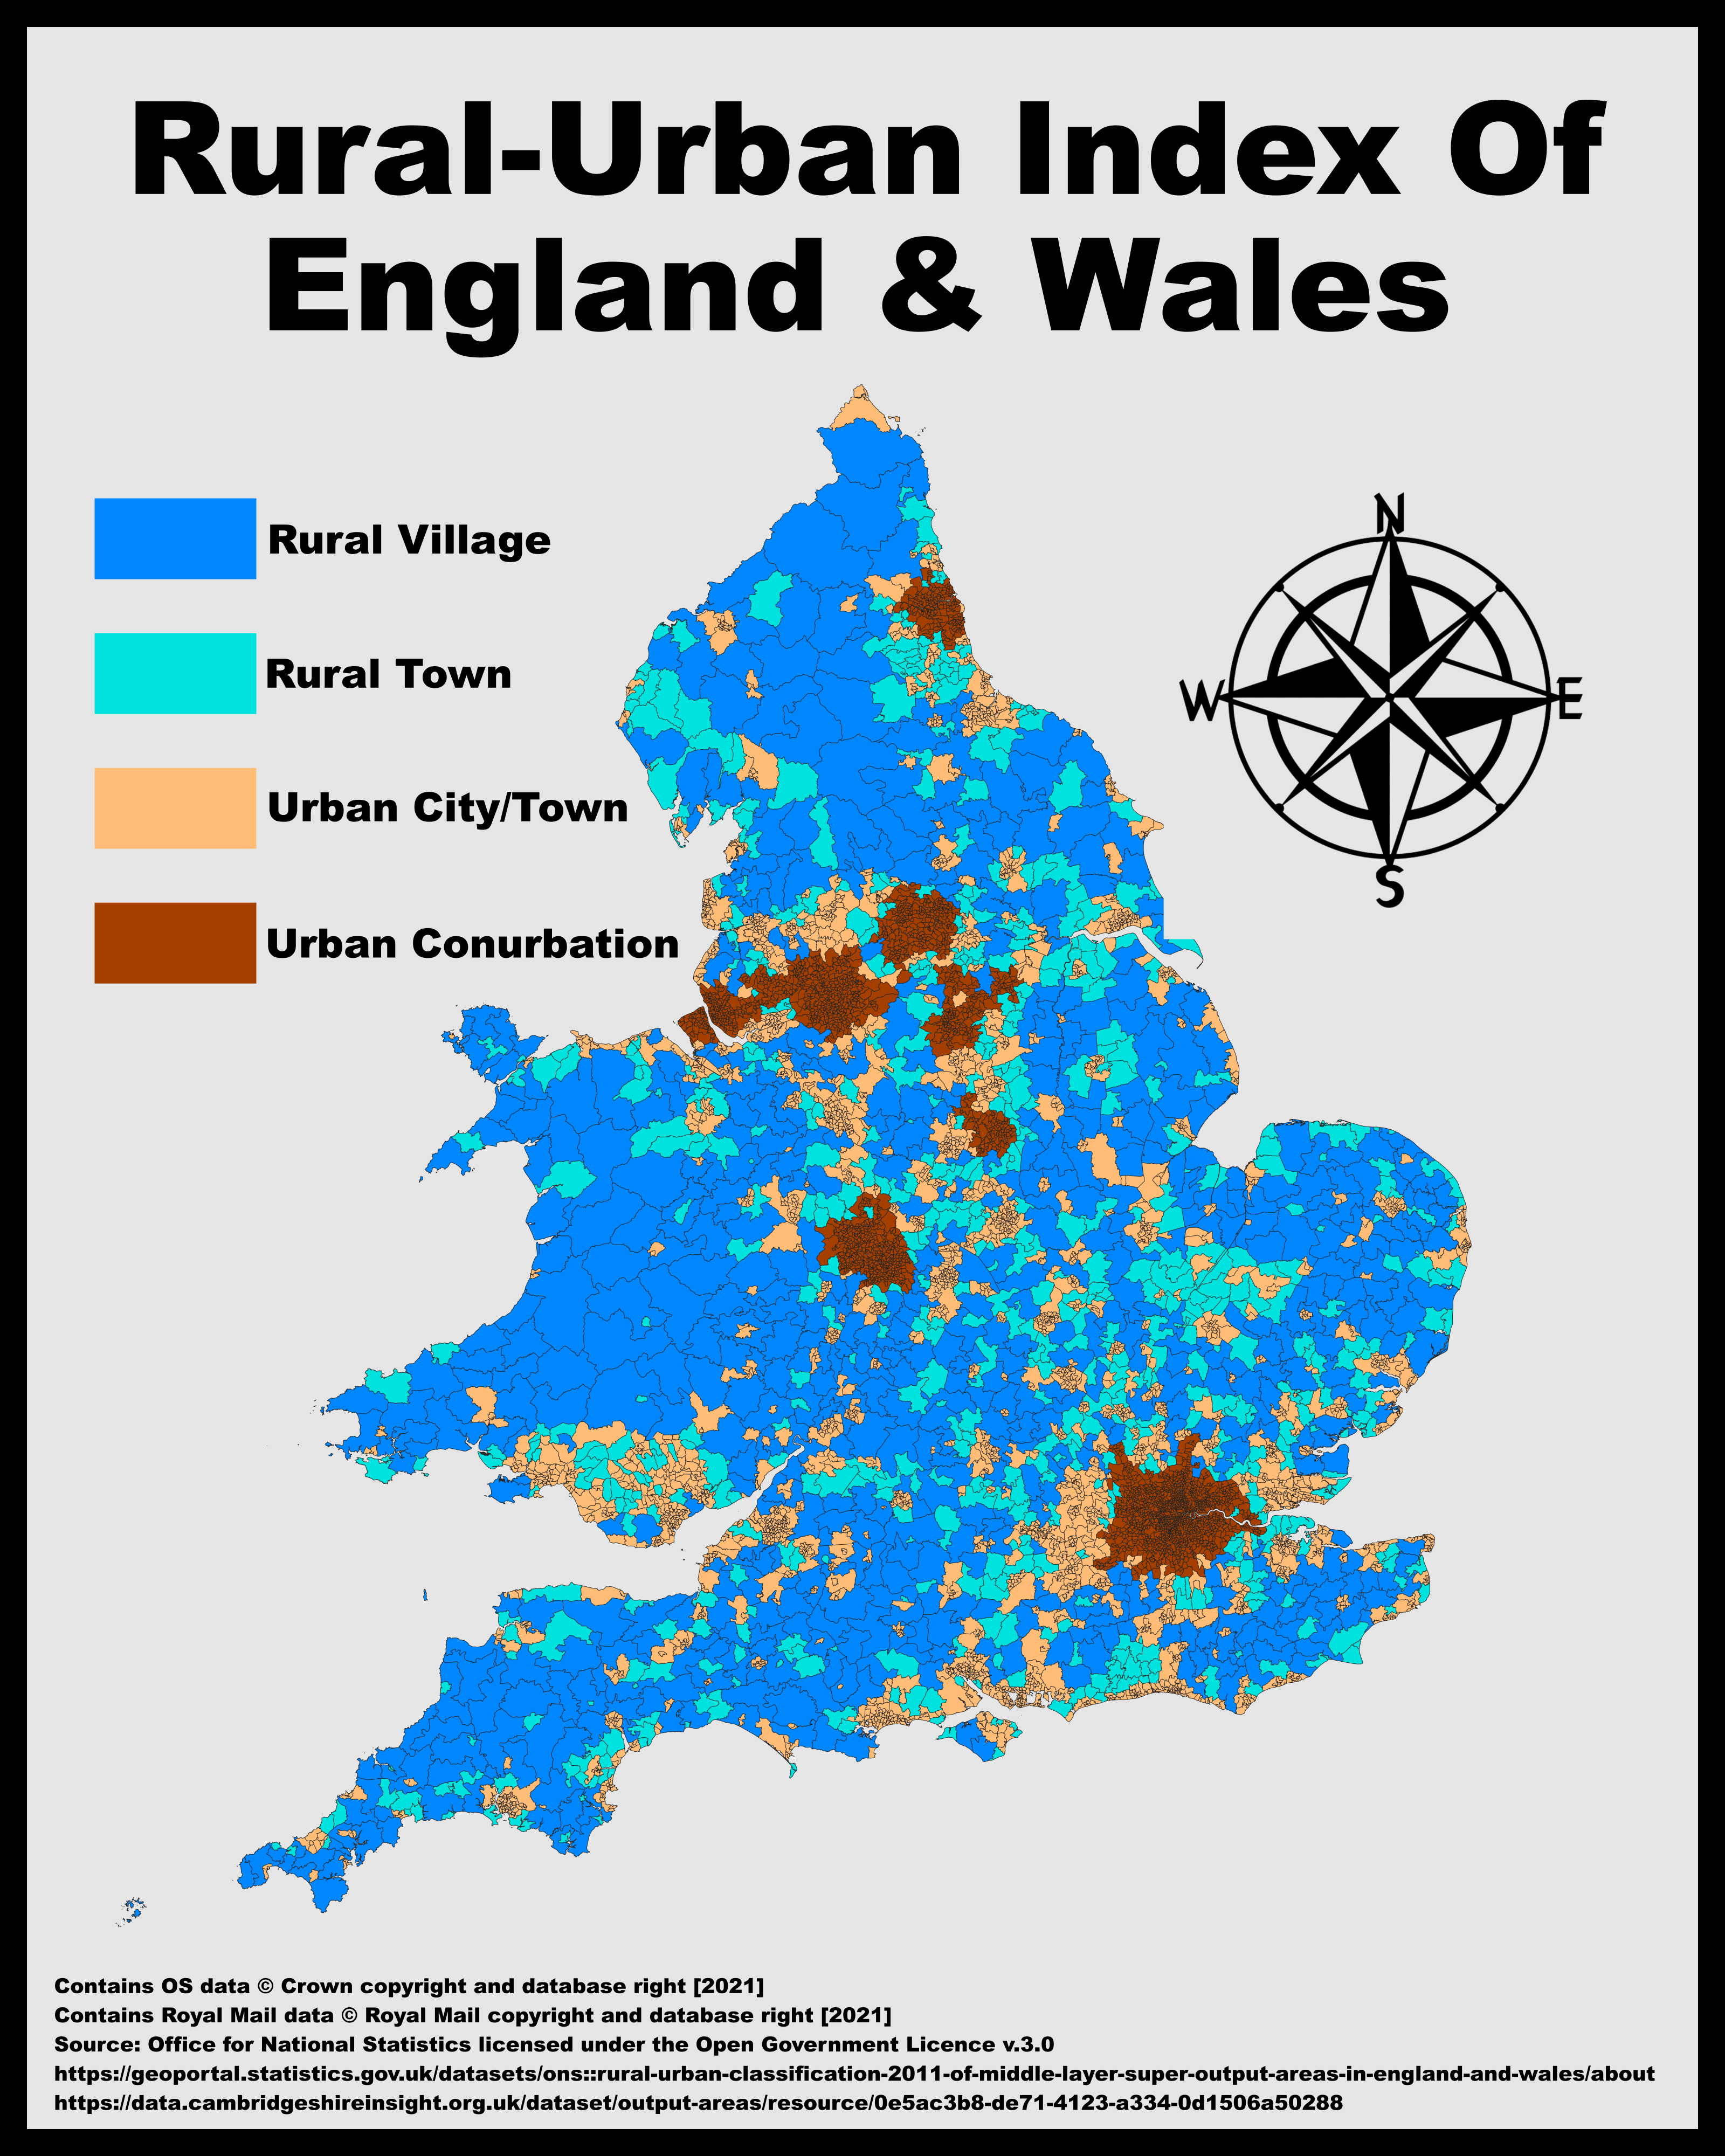

## Comments

As can be observed from the charts, South and South West of UK have a higher pets_per_household than other areas.
Comparing the heatmap we generated and the Rural-Urban Index of England and Wales, it seemed that people in rural areas tend to have more pets than people in urban areas.

# Part IV. County analysis

In [121]:
# create county dataset
county_grouped = df_merged.groupby('county').agg(
    population=('population', 'sum'),  
    num_households=('num_households', 'sum'),  
    cats_per_household=('cats_per_household',wm),
    dogs_per_household=('dogs_per_household', wm),
    pets_per_household=('pets_per_household', wm),
    estimated_pet_population=('estimated_pet_population', 'sum'),
    longitude=('longitude', 'mean'),
    latitude=('latitude', 'mean'),
    uk_region=('uk_region', 'max')
).reset_index()


# sort the data by pets_per_household
county_grouped.sort_values(by="pets_per_household",ascending=False, inplace=True)

# create a bar chart
fig = px.bar(county_grouped[:20], 
             x='county', 
             y=['dogs_per_household', 'cats_per_household'], 
             title='Pets per Household by County (Top 20)',
             barmode='group')  

fig.show()


In [122]:
# create center point
m = folium.Map(location=[df_merged['latitude'].mean()+1, df_merged['longitude'].mean()], zoom_start=6)\

#create colormap
colormap = branca.colormap.linear.Reds_09.scale(
    df_merged['pets_per_household'].min(), 
    df_merged['pets_per_household'].max()
)

colormap.add_to(m)

# add circlemarker for each county
for index, row in county_grouped.iterrows():
    color = colormap(row['pets_per_household'])
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['population']/70000,  
        color='orange',  
        weight=1,  
        fill=True,
        fill_color=color,  
        fill_opacity=1, 
        popup=f" Region: {row['uk_region']}<br> <br> County: {row['county']} <br><br>Population: {row['population']}<br><br>Pets per household: {row['pets_per_household']}",
    ).add_to(m)



top5= county_grouped.sort_values(by="pets_per_household", ascending = False)[:5]

# add marker for top 5 county
for idx, row in top5.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f" Region: {row['uk_region']}<br> <br> County: {row['county']} <br><br>Population: {row['population']}<br><br>Pets per household: {row['pets_per_household']}",
        icon=folium.DivIcon(html=f'''
                <div style="font-size: 14px; color: red; font-weight: bold; 
                            display: flex; justify-content: center; align-items: center; 
                            width: 25px; height: 25px; border-radius: 50%; 
                            background-color: black; color: red;">
                    {top5.index.get_loc(idx) + 1}
                </div>
            ''') 
    ).add_to(m)

    
# display
m


## Comments
It's interesting to see that the top 5 counties with highest pets_per_houshold scatter across UK. It's worth noticing that the county ranked second came from an island in Scotland

# Part VI. Relationship between population and pets ownership

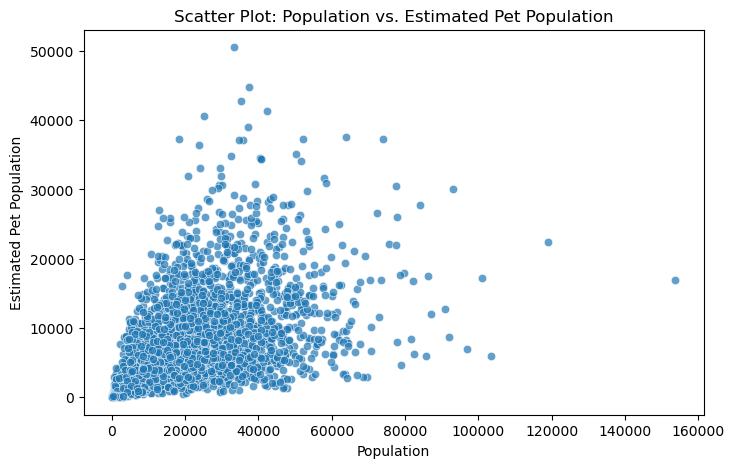

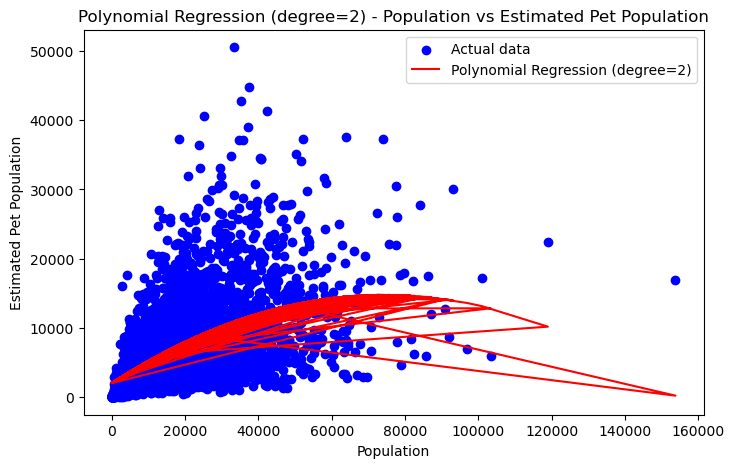

Pearson Correlation: 0.4891, p-value: 0.0000
Linear Regression R²: 0.2392
Linear Regression Slope: 0.1992, Intercept: 3469.0683
Polynomial Regression, R²: 0.2698


In [123]:
X = df_merged[['population']]
y = df_merged['estimated_pet_population']

# scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_merged["population"], y=df_merged["estimated_pet_population"], alpha=0.7)
plt.xlabel("Population")
plt.ylabel("Estimated Pet Population")
plt.title("Scatter Plot: Population vs. Estimated Pet Population")
plt.show()



# linear regression 
lin_model = LinearRegression()
lin_model.fit(X, y)
r2_linear = lin_model.score(X, y)

# scatter plot with regression line ---
fig = px.scatter(df_merged, x="population", y="estimated_pet_population", trendline="ols",
                 title="Population vs. Estimated Pet Population (with Regression Line)")
fig.show()


#polynomial 
# create a PolynomialFeatures object with degree=2 (quadratic)
poly = PolynomialFeatures(degree=2)

# transform the features
X_poly = poly.fit_transform(X)

# Fit a linear regression model 
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)

# generate predictions 
y_pred_poly = poly_reg_model.predict(X_poly)

# polynomial regression curve
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label="Actual data")
plt.plot(X, y_pred_poly, color='red', label="Polynomial Regression (degree=2)")
plt.xlabel("Population")
plt.ylabel("Estimated Pet Population")
plt.title("Polynomial Regression (degree=2) - Population vs Estimated Pet Population")
plt.legend()
plt.show()

# metrics
pearson_corr, pearson_p = pearsonr(df_merged["population"], df_merged["estimated_pet_population"])
r2_poly = r2_score(y, y_pred_poly)
print(f"Pearson Correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")
print(f"Linear Regression R²: {r2_linear:.4f}")
print(f"Linear Regression Slope: {lin_model.coef_[0]:.4f}, Intercept: {lin_model.intercept_:.4f}")
print(f"Polynomial Regression, R²: {r2_poly:.4f}")


In [124]:
#importing area data
url = 'https://en.wikipedia.org/wiki/List_of_English_districts_by_area'

tables = pd.read_html(url)
area = tables[0]

area

Rank                 District  Area (km2)  Area (mi2)  \
0       1          North Yorkshire        8037      3103.0   
1       2           Northumberland        5020      1940.0   
2       3  Westmorland and Furness        3756      1450.0   
3       4                 Cornwall        3545      1369.0   
4       5                 Somerset        3450      1330.0   
..    ...                      ...         ...         ...   
291   292   Hammersmith and Fulham          16         6.2   
292   293          Isles of Scilly          16         6.2   
293   294                Islington          15         5.8   
294   295   Kensington and Chelsea          12         4.6   
295   296           City of London           3         1.2   

                              Type Ceremonial county                    Region  
0                Unitary authority   North Yorkshire  Yorkshire and the Humber  
1                Unitary authority    Northumberland                North East  
2                Unitary authority           Cumbria                North West  
3                Unitary authority          Cornwall                South West  
4                Unitary authority          Somerset                South West  
..                             ...               ...                       ...  
291                 London borough    Greater London                    London  
292                    Sui generis          Cornwall                South West  
293                 London borough    Greater London                    London  
294  London borough, royal borough    Greater London                    London  
295         Sui generis, city (TI)    City of London                    London  

[296 rows x 7 columns]

In [125]:
#create a dataset to check if population density impacts pets ownership
county_grouped_area = county_grouped.merge(area, left_on ='county', right_on= 'District', how ='inner')
county_grouped_area.drop(columns=['Area (mi2)','Type','Ceremonial county', 'Region'], inplace = True)
county_grouped_area['population per km'] = county_grouped_area.apply(lambda row: row['population']/row['Area (km2)'], axis = 1)
county_grouped_area

county  population  num_households  cats_per_household  \
0    West Berkshire     38981.0         14804.0            1.183065   
1           Rutland     32521.0         12955.0            1.114012   
2          Torridge     37177.0         16773.0            0.971335   
3        South Hams     71163.0         31740.0            0.936984   
4        Chichester     30061.0         13035.0            0.920581   
..              ...         ...             ...                 ...   
252        Lewisham    300581.0        124528.0            0.081659   
253          Newham    325911.0        108281.0            0.080857   
254   Tower Hamlets    263451.0        105401.0            0.070494   
255       Southwark    175385.0         76226.0            0.057549   
256  City of London      5528.0          3402.0            0.032372   

     dogs_per_household  pets_per_household  estimated_pet_population  \
0              1.356764            2.539829              39612.510000   
1              1.277573            2.391585              34874.100000   
2              1.113947            2.085281              39086.510000   
3              1.074553            2.011537              74731.100000   
4              1.055742            1.976324              28053.290000   
..                  ...                 ...                       ...   
252            0.093648            0.175307              22050.344934   
253            0.092729            0.173586              19254.986879   
254            0.080844            0.151337              18759.115414   
255            0.065998            0.123547               9681.717394   
256            0.037124            0.069496                524.787620   

     longitude   latitude      uk_region  Rank        District  Area (km2)  \
0    -1.299006  51.417499     South East    47  West Berkshire         704   
1    -0.702520  52.656098  East Midlands    89         Rutland         382   
2    -4.245444  51.015442     South West    26        Torridge         984   
3    -3.799188  50.346724     South West    36      South Hams         887   
4    -0.622092  51.003036     South East    42      Chichester         786   
..         ...        ...            ...   ...             ...         ...   
252  -0.028565  51.459477         London   271        Lewisham          35   
253   0.026174  51.535596         London   268          Newham          36   
254  -0.050163  51.517071         London   290   Tower Hamlets          20   
255  -0.077625  51.484629         London   282       Southwark          29   
256  -0.092827  51.514721         London   296  City of London           3   

     population per km  
0            55.370739  
1            85.133508  
2            37.781504  
3            80.228861  
4            38.245547  
..                 ...  
252        8588.028571  
253        9053.083333  
254       13172.550000  
255        6047.758621  
256        1842.666667  

[257 rows x 14 columns]

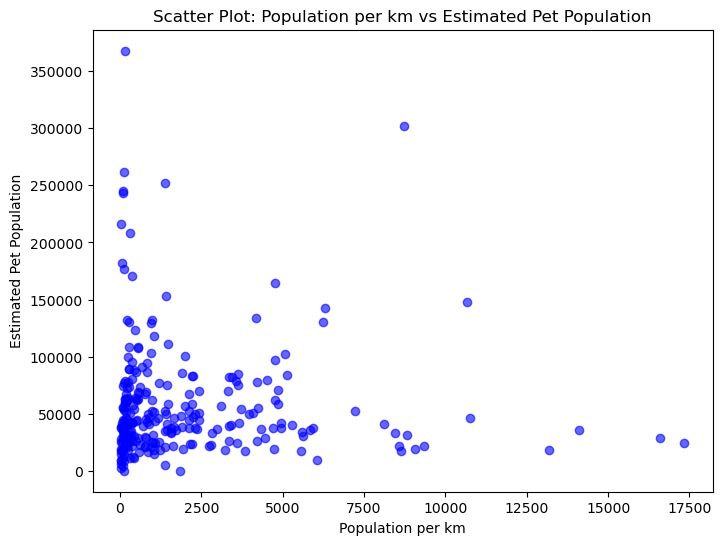

In [126]:
# scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(county_grouped_area['population per km'], county_grouped_area['estimated_pet_population'], color='blue', alpha=0.6)

plt.title('Scatter Plot: Population per km vs Estimated Pet Population')
plt.xlabel('Population per km')
plt.ylabel('Estimated Pet Population')

plt.show()


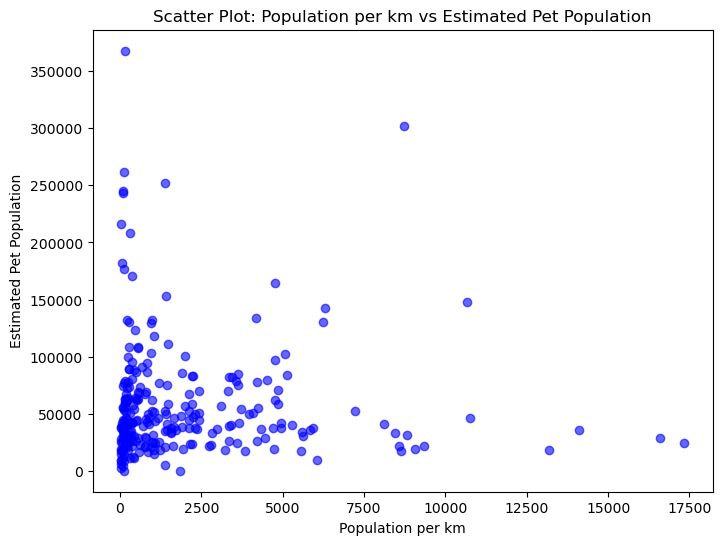

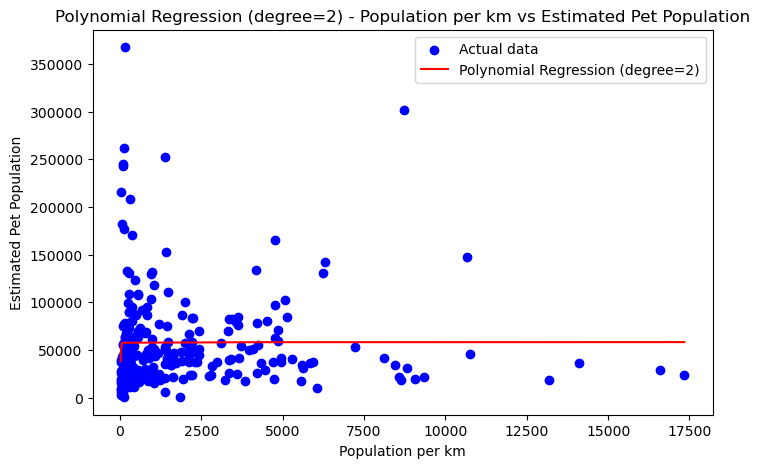

Pearson Correlation: -0.0297, p-value: 0.6353
Linear Regression R²: 0.0009
Linear Regression Slope: -0.5390, Intercept: 58615.7567
Polynomial Regression R²: 0.0016


In [127]:
# define X and y
X = county_grouped_area[['population per km']].values  # Reshaped for sklearn compatibility
y = county_grouped_area['estimated_pet_population'].values

# scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', alpha=0.6)
plt.title('Scatter Plot: Population per km vs Estimated Pet Population')
plt.xlabel('Population per km')
plt.ylabel('Estimated Pet Population')
plt.show()

# linear Regression
lin_model = LinearRegression()
lin_model.fit(X, y)
y_pred_linear = lin_model.predict(X)
r2_linear = lin_model.score(X, y)

# scatter plot with regression line
fig = px.scatter(county_grouped_area, x="population per km", y="estimated_pet_population", trendline="ols",
                 title="Population per km vs. Estimated Pet Population (with Regression Line)")
fig.show()

# polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)
y_pred_poly = poly_reg_model.predict(X_poly)

# polynomial regression curve
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label="Actual data")
plt.plot(np.sort(X, axis=0), np.sort(y_pred_poly), color='red', label="Polynomial Regression (degree=2)")
plt.xlabel("Population per km")
plt.ylabel("Estimated Pet Population")
plt.title("Polynomial Regression (degree=2) - Population per km vs Estimated Pet Population")
plt.legend()
plt.show()

# metrics
r2_poly = r2_score(y, y_pred_poly)
pearson_corr, pearson_p = pearsonr(X.flatten(), y)
print(f"Pearson Correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")
print(f"Linear Regression R²: {r2_linear:.4f}")
print(f"Linear Regression Slope: {lin_model.coef_[0]:.4f}, Intercept: {lin_model.intercept_:.4f}")
print(f"Polynomial Regression R²: {r2_poly:.4f}")


## Comments
1.There is a moderate, statistically significant positive relationship between population density and estimated pet population. However, the low R² values indicate that many other factors (e.g., household preferences, urban vs. rural differences, pet ownership regulations) influence pet population. While adding a polynomial term improves the model slightly, it does not drastically change the explanatory power.

2.Meanwhile, there is no meaningful relationship between population_per_km and estimated_pet_population. The very low R² values indicate that population density does not explain variations in pet population, implying other factors play a more significant role.